In [1]:
# !pip install yfinance
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import vector_space_translator
import shotgun


In [2]:
hist_df = yf.download([
    'AAPL',
    'MSFT',
    'SPY',
    'GOLD',
    'LOAN',
    'JMIA',
    'QQQ',
    'TSLA',
    'SNAP',
    'BSM',
    'ECCX',
]).dropna(how='any',axis=0)
hist_df

ret_df = hist_df['Adj Close']
ret_df = pd.DataFrame(
    data = np.log(ret_df.values[1:] / ret_df.values[:-1]),
    index = ret_df.iloc[1:].index,
    columns = ret_df.columns
)

ret_df.tail()

[*********************100%***********************]  11 of 11 completed


,AAPL,BSM,ECCX,GOLD,JMIA,LOAN,MSFT,QQQ,SNAP,SPY,TSLA
Date,,,,,,,,,,,
2022-07-18,-0.020859,0.022793,-0.002844,0.010165,0.016807,0.007326,-0.009668,-0.008499,0.019587,-0.008291,0.001997
2022-07-19,0.026371,0.017452,0.006892,0.013187,0.047025,0.003643,0.020554,0.030290,0.016388,0.026661,0.020505
2022-07-20,0.013419,0.011012,-0.009336,-0.036853,0.060001,0.005440,0.010502,0.015732,0.091770,0.006353,0.007991
2022-07-21,0.014981,-0.019351,0.001223,0.003231,0.013223,-0.001810,0.009751,0.014253,0.052743,0.010132,0.093312
2022-07-22,-0.008144,-0.008409,0.004471,-0.011028,-0.085669,-0.012762,-0.017061,-0.017691,-0.495651,-0.009321,0.001973


In [3]:
n_secs = 1_000
n_rows = 500
sigma = 0.3


cov_mat = np.random.normal(size=(n_secs,n_secs), scale=sigma, loc=sigma)
cov_mat = np.dot(cov_mat, cov_mat.T)

ret_df = pd.DataFrame(
    data = np.random.multivariate_normal(
        mean = np.zeros(n_secs),
        cov = cov_mat,
        size=n_rows
    ),
    columns = np.arange(n_secs)
)

ret_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-2.906666,-7.501480,4.238913,-3.888887,2.416722,-6.774138,-1.823999,-11.923907,-1.070020,-0.094948,...,-9.183249,1.169788,-7.746565,1.526152,-0.727723,10.541289,-9.531656,5.600707,-11.885208,-2.380706
1,-20.827222,1.927121,-13.568180,-14.062409,-0.234721,-5.503069,5.984444,-20.590866,6.524200,-10.358726,...,-5.619833,13.717091,2.745189,-2.995962,-0.085507,5.290801,-20.894148,-10.313069,4.040205,-8.819690
2,3.715865,9.594267,14.703008,-3.309700,8.581451,20.408410,-13.969348,2.306133,3.210926,10.642003,...,12.699677,-2.349214,7.717500,-4.062112,-6.525212,4.171112,11.946407,7.585315,1.700954,13.740203
3,7.197565,10.888478,14.104572,-6.631458,0.672865,-4.733423,3.966592,33.046680,13.116220,15.323320,...,5.564269,6.908717,10.611781,9.963487,22.665567,0.015889,19.044154,15.232671,7.523649,10.796998
4,8.983435,-0.107907,2.258264,-4.865514,0.856102,24.577246,-6.355098,10.078198,7.673671,-11.106524,...,11.225390,5.524377,-4.339459,-5.570522,11.621648,1.863003,7.612434,28.498932,1.223779,10.854097


In [4]:
# portf_initial = np.array([
#     # 1,0,0,0,0,0,0,0,0,0,0
# ])
portf_initial = np.zeros(n_secs)
portf_initial[0] = -3
portf_initial[12] = 8
portf_initial[100] = 0.9

can_trade_mask = np.where(portf_initial, 0, 1)

vec_txl = vector_space_translator.VectorSpaceTranslator(
    ignore_mask = 1-can_trade_mask
)
def var_eval_func(weights):
    full_weights = vec_txl.decode(weights, axis=1)
    portf = portf_initial + full_weights
    pl_ts = portf @ ret_df.values.T
    var = np.var(pl_ts, axis=1)
    return var

In [5]:


config = shotgun.ShotgunOptimizeConfig(
    sigma_start = 2.0,
    search_size = 15_000,
    max_iter = 2_000,
    pp_param = 0.4,
    sigma_tol = 1e-7,
    convergence_steps_lookback = 3,
    convergence_steps_tol = 1/50,
)
x0 = np.zeros(vec_txl.inner_size())
f = var_eval_func

# res = shotgun.shotgun_optimize_simple(
shotgun_obj = shotgun.ShotgunOptimizer(
    objective_func = f,
    config = config,
)
res = shotgun_obj.run(
    x0 = x0,
    verbose = True,
)


res['success'], res['stop_reason'], res['fx'], res['n_iter']
# res.keys()

iter 0, sigma 2.00 (best fx 10,239.6484)
using search size 15,000
convergence progress: 0%
iter 1, sigma 1.00 (best fx 10,239.6484)
using search size 15,000
convergence progress: 0%
iter 2, sigma 0.50 (best fx 10,239.6484)
using search size 15,000
convergence progress: 0%
iter 3, sigma 0.25 (best fx 10,239.6484)
using search size 15,000
convergence progress: 0%
iter 4, sigma 0.06 (best fx 9,953.0296)
using search size 15,000
convergence progress: 0%
iter 5, sigma 0.07 (best fx 9,566.2648)
using search size 15,000
convergence progress: 0%
iter 6, sigma 0.07 (best fx 9,181.2505)
using search size 15,000
convergence progress: 6%
iter 7, sigma 0.07 (best fx 8,828.9190)
using search size 14,418
convergence progress: 30%
iter 8, sigma 0.08 (best fx 8,627.2797)
using search size 12,280
convergence progress: 57%
iter 9, sigma 0.08 (best fx 8,484.6151)
using search size 9,835
convergence progress: 52%
iter 10, sigma 0.09 (best fx 8,240.7243)
using search size 10,327
convergence progress: 52%
it

(True, 'convergence', 1250.1593510732516, 223)

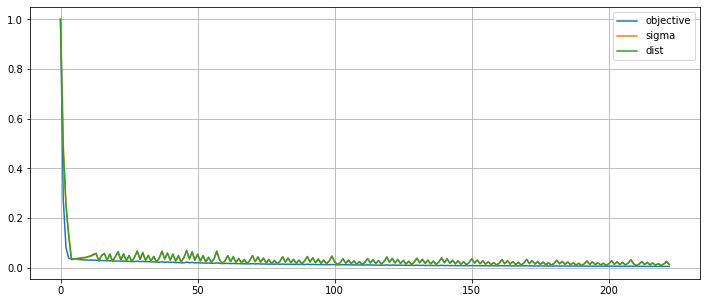

In [6]:
fig, ax = plt.subplots(figsize=(12,5))

def normalize(xx):
    ys = np.asarray(xx)/xx[0]
    # return np.log(ys)
    return ys


ax.plot(
    np.arange(res['n_iter']),
    normalize(res['history']['fx']),
    label='objective'
)

ax.plot(
    np.arange(res['n_iter']),
    normalize(res['history']['sigma']),
    label='sigma'
)

ax.plot(
    np.arange(res['n_iter']),
    normalize(res['history']['dist']),
    label='dist'
)

ax.legend()
ax.grid()

plt.show()


In [7]:
opt_res_df = pd.DataFrame(res['history']).drop(columns=['xx'])

opt_res_df.round(6)#.loc[opt_res_df['step_success']]

,fx,sigma,dist,dist_percentile,step_success
0,267795.673668,2.000000,60.708524,0.0,False
1,73398.849661,1.000000,28.551070,0.0,False
2,21739.241960,0.500000,15.321224,0.0,False
3,9953.029626,0.250000,7.910607,0.0,True
4,9566.264834,0.063526,1.995563,0.0,True
...,...,...,...,...,...
218,1291.116907,0.031924,0.989292,0.0,False
219,1258.386014,0.015962,0.503258,0.0,True
220,1251.790787,0.027934,0.867147,0.0,True
221,1333.399133,0.048884,1.554324,0.0,False


In [8]:
good_df = opt_res_df.loc[opt_res_df['step_success']].reset_index(drop=True)

good_df

,fx,sigma,dist,dist_percentile,step_success
0,9953.029626,0.250000,7.910607,0.0,True
1,9566.264834,0.063526,1.995563,0.0,True
2,9181.250518,0.066125,2.130182,0.0,True
3,8828.918958,0.069478,2.202809,0.0,True
4,8627.279730,0.073599,2.347938,0.0,True
...,...,...,...,...,...
121,1305.168249,0.020848,0.645885,0.0,True
122,1284.359919,0.018242,0.588130,0.0,True
123,1258.386014,0.015962,0.503258,0.0,True
124,1251.790787,0.027934,0.867147,0.0,True


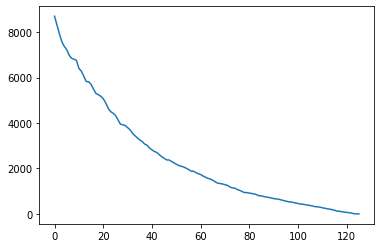

In [9]:
def deriv(xx, fx):
    return (fx[1:] - fx[:-1]) / (xx[1:] - xx[:-1])


good_df['fx'].iloc[0] - good_df['fx'].iloc[5]

(good_df['fx'].iloc[-2] - good_df['fx'].iloc[-1])

plt.plot(
    good_df['fx'] - good_df['fx'].iloc[-1]
)

In [10]:

dj = good_df['fx'].diff(-3).dropna()

dj/dj[0]


0      1.000000
1      0.835314
2      0.619721
3      0.523253
4      0.468153
         ...   
118    0.037018
119    0.039131
120    0.049916
121    0.047484
122    0.030425
Name: fx, Length: 123, dtype: float64